program for binary classification 


here are instructions given after every steps in program to run it 

load imports 

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
from fastai.vision import *

### Data

here i have imported the drive if you want to import this drive then please mail me at bhosale1prathmesh@gmail.com i will share drive instantaneously 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


this is for kaggle , if you want to take the data set form kaggle where i have uploaded it for the binary class then go with this step

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/prathmeshbhosale/xray-covid-vs-normal')

Skipping, found downloaded files in "./xray-covid-vs-normal" (use force=True to force download)


here i have importd it form both kaggle and g drive so i can give any path so i have chosen here path of kaggle you will need your kaggle account and there you will get the token hich is having pass and username then this can access 

In [ ]:
path = Path('/content/xray-covid-vs-normal/upload_by_pratham_xray')
#path = Path('/content/drive/MyDrive/Colab Notebooks/upload_by_pratham_xray')

here we are giving path,batch size, train folder validation folder 

In [ ]:
np.random.seed(41)
data = ImageDataBunch.from_folder(path, train="train", valid ="val",
        ds_tfms=get_transforms(), size=(256,256), bs=32, num_workers=4).normalize()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


data class, train data length ,test data length

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['covid', 'normal'], 2, 2000, 800)

In [ ]:
print("Number of examples in training:", len(data.train_ds))
print("Number of examples in validation:", len(data.valid_ds))

Number of examples in training: 2000
Number of examples in validation: 800


In [ ]:
xb,yb = data.one_batch()
xb.shape,yb.shape

(torch.Size([32, 3, 256, 256]), torch.Size([32]))

Sample images from the dataset

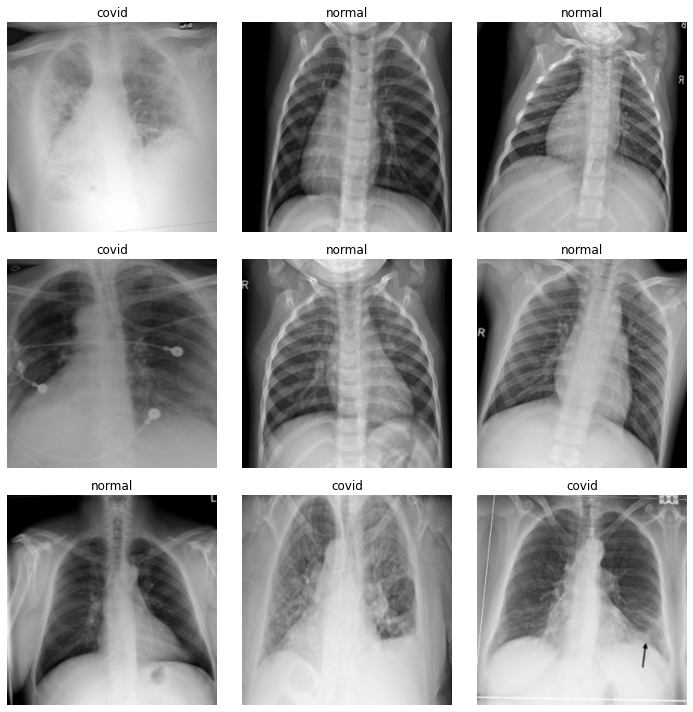

In [ ]:

data.show_batch(rows=3, figsize=(10,10))

## proposed DarkCovidNet model 

In [ ]:
def conv_block(ni, nf, size=3, stride=1):
    for_pad = lambda s: s if s > 2 else 3
    return nn.Sequential(
        nn.Conv2d(ni, nf, kernel_size=size, stride=stride,
                  padding=(for_pad(size) - 1)//2, bias=False), 
        nn.BatchNorm2d(nf),
        nn.LeakyReLU(negative_slope=0.1, inplace=True)  
    )

In [ ]:
def triple_conv(ni, nf):
    return nn.Sequential(
        conv_block(ni, nf),
        conv_block(nf, ni, size=1),  
        conv_block(ni, nf)
    )

In [ ]:
def maxpooling():
    return nn.MaxPool2d(2, stride=2)

cnn sequential of model 

In [ ]:
model = nn.Sequential(
    conv_block(3, 8),
    maxpooling(),
    conv_block(8, 16),
    maxpooling(),
    triple_conv(16, 32),
    maxpooling(),
    triple_conv(32, 64),
    maxpooling(),
    triple_conv(64, 128),
    maxpooling(),
    triple_conv(128, 256),
    conv_block(256, 128, size=1),
    conv_block(128, 256),
    conv_layer(256, 2),
    Flatten(),
    nn.Linear(338, 2)
)

In [ ]:
learn = Learner(data, model, loss_func = nn.CrossEntropyLoss(), metrics=accuracy)

In [ ]:
print(learn.summary())

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [8, 256, 256]        216        True      
______________________________________________________________________
BatchNorm2d          [8, 256, 256]        16         True      
______________________________________________________________________
LeakyReLU            [8, 256, 256]        0          False     
______________________________________________________________________
MaxPool2d            [8, 128, 128]        0          False     
______________________________________________________________________
Conv2d               [16, 128, 128]       1,152      True      
______________________________________________________________________
BatchNorm2d          [16, 128, 128]       32         True      
______________________________________________________________________
LeakyReLU            [16, 128, 128]       0          False     
___________________________________________________

training and testing 

In [ ]:
learn.fit_one_cycle(100, max_lr=3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.196672,0.065857,0.985000,00:26
1,0.153335,0.080896,0.973750,00:26
2,0.136856,0.097970,0.972500,00:26
3,0.135930,0.064297,0.983750,00:26
4,0.126989,0.068493,0.987500,00:26
5,0.129494,0.055481,0.982500,00:26
6,0.138298,0.101473,0.971250,00:26
7,0.122841,0.114361,0.958750,00:26
8,0.126737,0.072205,0.988750,00:26
9,0.122935,0.090684,0.962500,00:26


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**plots of accuracy and losses vs batches processed**

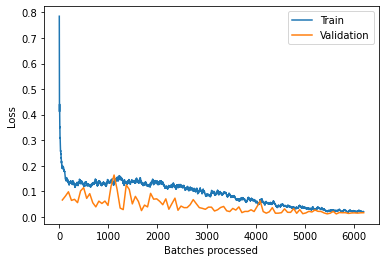

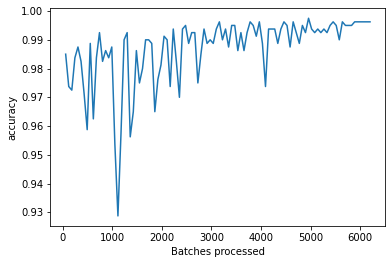

In [ ]:
learn.recorder.plot_losses()
learn.recorder.plot_metrics()


In [ ]:
print("Number of examples in testing:", len(data.valid_ds))

Number of examples in testing: 800


In [ ]:
probs,targets = learn.get_preds(ds_type=DatasetType.Valid) 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**accuracy**

In [ ]:
accuracy(probs,targets)

tensor(0.9962)

In [ ]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['covid', 'normal'], 2, 2000, 800)

**precision ,  recall , f1-score**

In [ ]:
probs = np.argmax(probs, axis=1)
correct = 0
for idx, pred in enumerate(probs):
    if pred == targets[idx]:
        correct += 1
accuracy = correct / len(probs)
print(len(probs), correct, accuracy)

from sklearn.metrics import confusion_matrix
np.set_printoptions(threshold=np.inf) 
cm1 = confusion_matrix(targets, probs)
print(cm1)

from sklearn.metrics import classification_report
y_true1 = targets
y_pred1 = probs
target_names = ['Covid-19', 'No_findings']
print(classification_report(y_true1, y_pred1, target_names=target_names))

800 797 0.99625
[[397   3]
 [  0 400]]
              precision    recall  f1-score   support

    Covid-19       1.00      0.99      1.00       400
 No_findings       0.99      1.00      1.00       400

    accuracy                           1.00       800
   macro avg       1.00      1.00      1.00       800
weighted avg       1.00      1.00      1.00       800



In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


**confusion matrix**

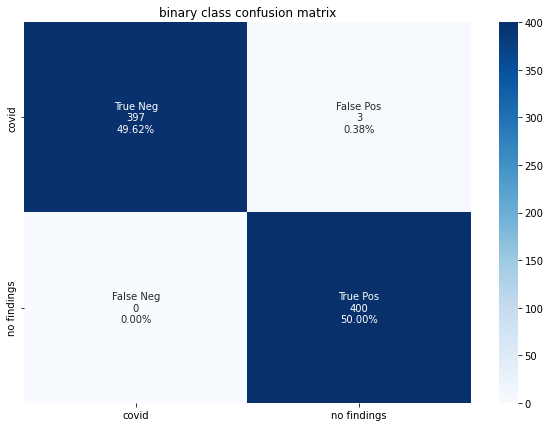

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (10,7))
plt.title('binary class confusion matrix')

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts =[ "{0:0.0f}".format(value) for value in 
                    cm1.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     cm1.flatten()/np.sum(cm1)]
categories = ['covid' , 'no findings']

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm1, annot=labels, fmt='', cmap='Blues',xticklabels=categories,yticklabels=categories)

